## Predicting heart disease using machine learning
This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Importing data

In [2]:
df = pd.read_csv("heart-disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Data Exploration (exploratory data analysis or EDA)
The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [3]:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

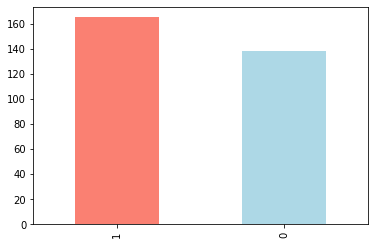

In [4]:
df["target"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

## Heart disease frequency according to sex

In [5]:
df["sex"].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [6]:
pd.crosstab(df["target"],df["sex"])

sex,0,1
target,,
0,24,114
1,72,93


#### '0' in sex means female and '1' for male

### Plotting crosstabs

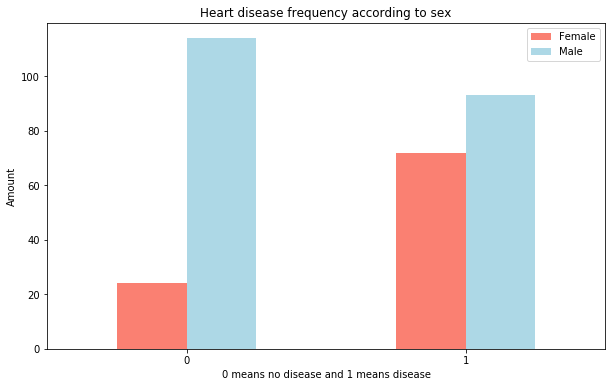

In [7]:
pd.crosstab(df.target, df.sex).plot(kind="bar",
                                 figsize=(10,6),
                                 color=["salmon", "lightblue"])
plt.title("Heart disease frequency according to sex")
plt.xlabel("0 means no disease and 1 means disease")
plt.ylabel("Amount")
plt.legend(["Female","Male"])
plt.xticks(rotation=0); # To rotate the 0 and 1 below the bar

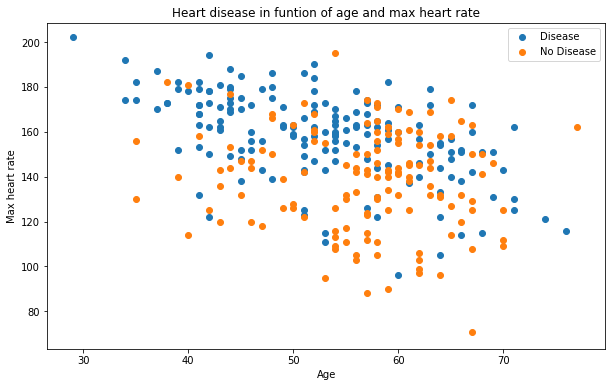

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

# Scatter with positive examples
scatter = ax.scatter(x=df.age[df.target==1],
                     y=df.thalach[df.target==1],
                     label="Disease",
                     cmap="winter")

#Scatter with negative examples
scatter = ax.scatter(x=df.age[df.target==0],
                     y=df.thalach[df.target==0],
                     label="No Disease",
                     cmap="summer");

# Customise
ax.set(title="Heart disease in funtion of age and max heart rate",
       xlabel="Age",
       ylabel="Max heart rate")

# Set up a legend
ax.legend();

### Heart disease frequency per chest pain types

1. cp-chest pain type
 * 0: Typical angina: chest pain related decrease blood supply to the heart
 * 1: Atypical angina: chest pain not related to heart
 * 2: Non-anginal pain: typically esophageal spasms (non heart related)
 * 3: Asymptomatic: chest pain not showing signs of disease

In [9]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


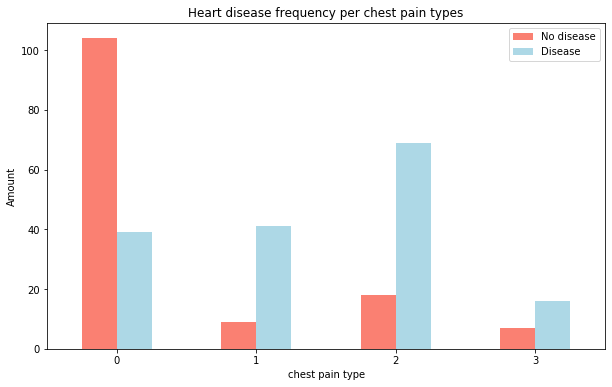

In [10]:
# Visualise the crosstab

pd.crosstab(df.cp, df.target).plot(kind="bar", figsize=(10,6),
                                   color=["salmon", "lightblue"])
plt.title("Heart disease frequency per chest pain types")
plt.xlabel("chest pain type")
plt.ylabel("Amount")
plt.legend(["No disease", "Disease"])
plt.xticks(rotation=0);

In [11]:
df.corr() # Shows how each row differs with one another

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


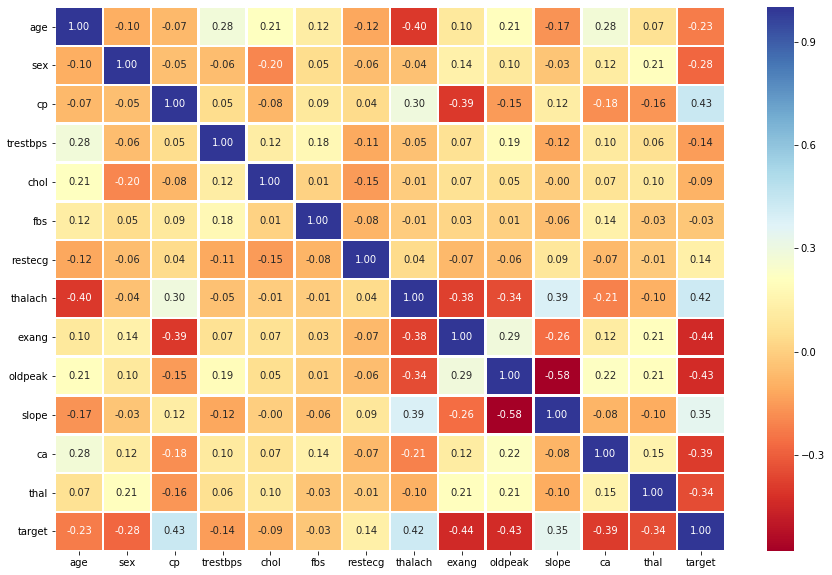

In [12]:
# Visualise correlational matrix
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_mat,
                 annot=True,
                 fmt=".2f",
                 linewidth=1.5,
                 cmap="RdYlBu");

## 5. Modelling

In [13]:
# Split data into x and y

x = df.drop("target", axis=1)
y = df["target"]

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)



Now we've got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 3 different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier

In [14]:
# Put models in a dictionary
model = {"Logistic Regression": LogisticRegression(),
         "Random Forest":RandomForestClassifier(),
         "KNN": KNeighborsClassifier()}

# Create function to fit and score models
def fit_and_score(model, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores={}
    # Loop through models
    for name,model in model.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to the model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [15]:
model_scores = fit_and_score(model, x_train, x_test, y_train, y_test)
model_scores

F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Logistic Regression': 0.8688524590163934,
 'Random Forest': 0.8524590163934426,
 'KNN': 0.6885245901639344}

###  Model Comparison

In [16]:
model_compare = pd.DataFrame(model_scores, index = ["Score"])
model_compare.shape

(1, 3)

In [17]:
type(model_compare)

pandas.core.frame.DataFrame

In [18]:
model_compare

,Logistic Regression,Random Forest,KNN
Score,0.868852,0.852459,0.688525


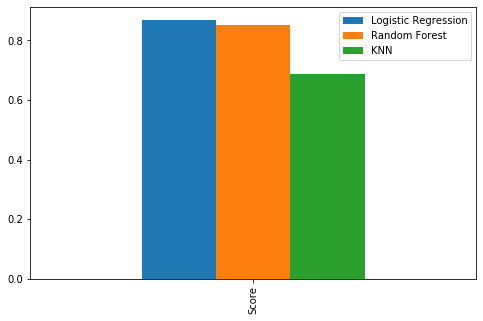

In [19]:
model_compare.plot.bar(figsize=(8,5));

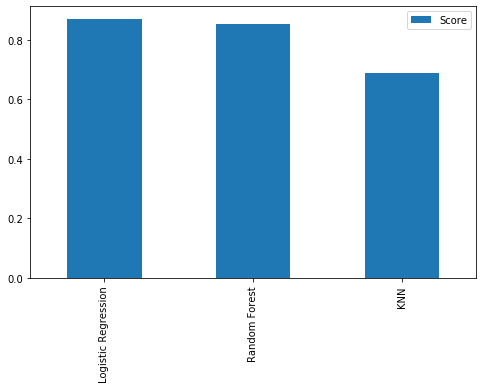

In [20]:
model_compare.T.plot.bar(figsize=(8,5))
"""
When we try to make a bar plot from a dataframe, the index column is always taken at x-axis.
That is why here, we are taking the transpose and then plotting the dataframe.
""";

Now we've got a baseline model... and we know a model's first predictions aren't always what we should based our next steps off. What should we do?

Let's look at the following:

* Hyperparameter tuning
* Feature importance
* Confusion matrix
* Cross-validation
* Precision
* Recall
* F1 score
* Classification report
* ROC curve
* Area under the curve (AUC)

## Hyperparameter tuning (By hand)

In [21]:

# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Instantiate the model
knn = KNeighborsClassifier()

# Loop through the model
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(x_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(x_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(x_test, y_test))

In [22]:
train_scores

[1.0,
 0.8099173553719008,
 0.7727272727272727,
 0.743801652892562,
 0.7603305785123967,
 0.7520661157024794,
 0.743801652892562,
 0.7231404958677686,
 0.71900826446281,
 0.6942148760330579,
 0.7272727272727273,
 0.6983471074380165,
 0.6900826446280992,
 0.6942148760330579,
 0.6859504132231405,
 0.6735537190082644,
 0.6859504132231405,
 0.6652892561983471,
 0.6818181818181818,
 0.6694214876033058]

The maximum accuracy of the model is 75.41%


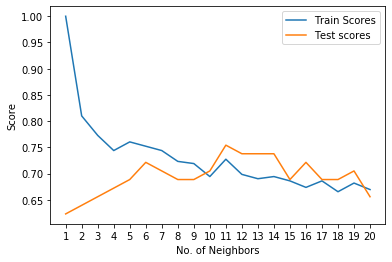

In [23]:
plt.plot(neighbors, train_scores, label="Train Scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xlabel("No. of Neighbors")
plt.ylabel("Score")
plt.xticks(np.arange(1,21,1))
plt.legend()

print(f"The maximum accuracy of the model is {max(test_scores)*100:.2f}%")

## Hyperparameter tuning with RandomizedSearchCV

We're going to tune:
1. Logistic Regression
2. Random Forest Classifier

using RandomizedSearchCV

In [24]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

In [25]:
# Tune Logistics Regression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                verbose=True,
                                cv=5,
                                n_iter=20)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=20, n_jobs=None,
                   param_distributi...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

In [26]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [27]:
rs_log_reg.score(x_test,y_test)

0.8852459016393442

Now we've tuned LogisticRegression(), let's do the same for RandomForestClassifier()...

In [28]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished
F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [29]:
rs_rf.best_params_

{'n_estimators': 560,
 'min_samples_split': 12,
 'min_samples_leaf': 15,
 'max_depth': 3}

In [30]:
rs_rf.score(x_test, y_test)

0.8688524590163934

In [31]:
model_scores

{'Logistic Regression': 0.8688524590163934,
 'Random Forest': 0.8524590163934426,
 'KNN': 0.6885245901639344}

In [32]:
model_scores["Logistic Regression"]=rs_log_reg.score(x_test, y_test)

In [33]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'Random Forest': 0.8524590163934426,
 'KNN': 0.6885245901639344}

## Hyperparameter tuning using GridSearchCV
Since our LogisticRegression model provides the best scores so far, we'll try and improve them again using GridSearchCV...

In [34]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          cv=5,
                          param_grid=log_reg_grid, 
                          verbose=True)

gs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished
F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.0000000...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.

In [35]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [36]:
gs_log_reg.score(x_test, y_test)

0.8852459016393442

In [37]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'Random Forest': 0.8524590163934426,
 'KNN': 0.6885245901639344}

### Evaluting our tuned machine learning classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score
... and it would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [39]:
y_pred = gs_log_reg.predict(x_test)
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [43]:
y_proba = gs_log_reg.predict_proba(x_test)
len(y_proba)

61

In [44]:
y_proba_positive = y_proba[:,1]
y_proba_positive[:10]

array([0.13274726, 0.75591495, 0.81452422, 0.05469223, 0.88453356,
       0.87070297, 0.60512178, 0.00435981, 0.01376377, 0.56138458])

In [46]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, threshold = roc_curve(y_test, y_proba_positive)

In [57]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, label="ROC", color="orange")
    plt.title("False positive rate vs. True positive rate")
    plt.xlabel("True positve rate")
    plt.ylabel("False positive rate")
    plt.legend()
    

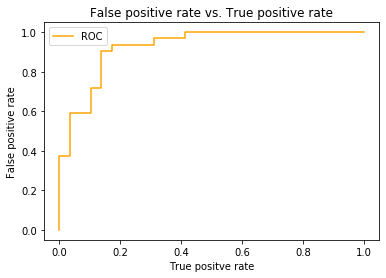

In [58]:
plot_roc_curve(fpr, tpr)

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_proba_positive)

0.925646551724138

In [60]:
# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

[[25  4]
 [ 3 29]]


In [71]:
# Visualise confusion matrix
sns.set(font_scale=1.5)
def plot_conf_mat(y_test, y_proba):
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                     annot=True,
                     cmap="OrRd_r")

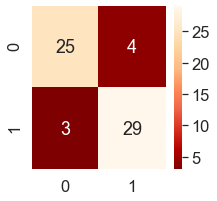

In [72]:
plot_conf_mat(y_test, y_proba)

Now we've got a ROC curve, an AUC metric and a confusion matrix, let's get a classification report as well as cross-validated precision, recall and f1-score.

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



## Calculate evaluation metrics using cross-validation
We're going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using `cross_val_score()`.

In [74]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [75]:
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

In [76]:
cvs = cross_val_score(clf, 
                      x, 
                      y, 
                      cv=5,
                      scoring="accuracy")
cvs

array([0.81967213, 0.90163934, 0.86885246, 0.88333333, 0.75      ])

In [78]:
# Calculate Accuracy
cvs = cvs.mean()

In [81]:
# Calculating precision 
cvs_precision = cross_val_score(clf, x , y, cv=5, scoring="precision")
cvs_precision = cvs_precision.mean()

In [83]:
# Calculate recall
cvs_recall = cross_val_score(clf, x, y, cv=5, scoring="recall")
cvs_recall = cvs_recall.mean()

In [84]:
# Calculate f1
cvs_f1 = cross_val_score(clf, x, y, cv=5, scoring="f1")
cvs_f1 = cvs_f1.mean()

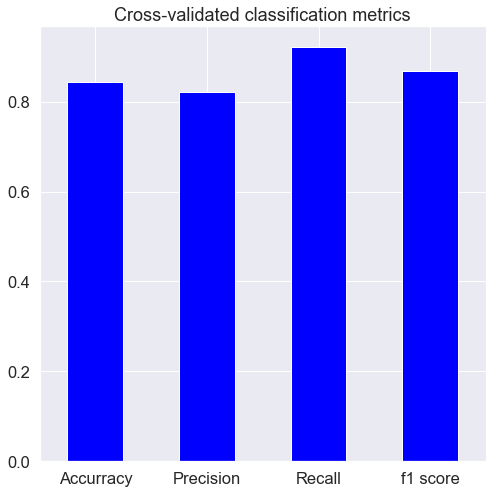

In [106]:
cv_metrics = pd.DataFrame({"Accurracy":cvs,
                           "Precision":cvs_precision,
                           "Recall":cvs_recall,
                           "f1 score":cvs_f1},
                           index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      figsize=(8,8), 
                      cmap="winter",
                      legend=False,)
plt.xticks(rotation=0);

### Feature Importance
Feature importance is another as asking, "which features contributed most to the outcomes of the model and how did they contribute?"

Finding feature importance is different for each machine learning model. One way to find feature importance is to search for "(MODEL NAME) feature importance".

Let's find the feature importance for our LogisticRegression model...

In [107]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [109]:
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

clf.fit(x_train, y_train);

In [115]:
clf.coef_.shape # .coef_ shows how much each feature contributes to the model's correct predictions

(1, 13)

In [116]:
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672801993431563,
 'sex': -0.8604465072345515,
 'cp': 0.6606704082033799,
 'trestbps': -0.01156993168080875,
 'chol': -0.001663744504776871,
 'fbs': 0.043861071652469864,
 'restecg': 0.31275846822418324,
 'thalach': 0.024593613737779126,
 'exang': -0.6041308000615746,
 'oldpeak': -0.5686280368396555,
 'slope': 0.4505162797258308,
 'ca': -0.6360989676086223,
 'thal': -0.6766337263029825}

In [118]:
# Visualise feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.003167,-0.860447,0.66067,-0.01157,-0.001664,0.043861,0.312758,0.024594,-0.604131,-0.568628,0.450516,-0.636099,-0.676634


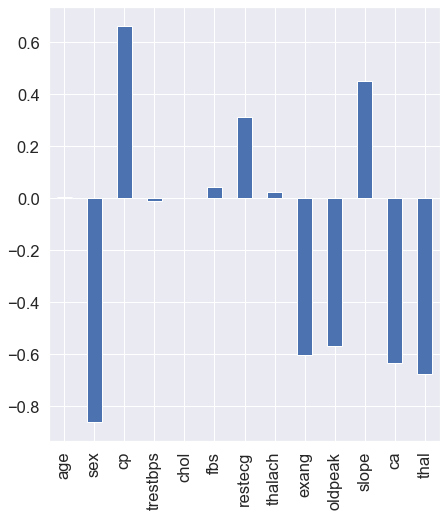

In [131]:
feature_df.T.plot.bar(figsize=(7,8), legend=False);